In [19]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from pydicom import Dataset

from medmnist import BreastMNIST
from medmnist import INFO

import pennylane as qml

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU.")

Using: NVIDIA GeForce RTX 4070 Ti SUPER
CUDA: 12.4


In [21]:
class INbreastDataset(Dataset):
    def __init__(self, root_dir, train=True, data_augmentation=True):
        self.image_paths = []
        self.labels = []

        base_transform = [transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

        if train and data_augmentation:
            augmentation_transform = [transforms.RandomHorizontalFlip(p=0.5),  
                                    transforms.RandomRotation(degrees=15),  
                                    transforms.ToTensor(),]
            self.transform = transforms.Compose(base_transform + augmentation_transform)
        else:
            self.transform = transforms.Compose(base_transform)

        for label in ['0', '1']:
            folder_path = os.path.join(root_dir, label)
            self.image_paths.extend([os.path.join(folder_path, img_name) for img_name in os.listdir(folder_path)])
            self.labels.extend([int(label)] * len(os.listdir(folder_path)))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [22]:
# train_dir = '/home/eflammere/QuantumIC/Datasets/INbreast/png/train'
# test_dir = '/home/eflammere/QuantumIC/Datasets/INbreast/png/test'

# train_dataset = INbreastDataset(root_dir=train_dir, data_augmentation=False)
# test_dataset = INbreastDataset(root_dir=test_dir, train=False)

# train_loader = INbreastDataset(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = INbreastDataset(test_dataset, batch_size=batch_size, shuffle=False)

# **BreastMNIST**

In [23]:
info = INFO['breastmnist']
data_flag = 'breastmnist'
DataClass = BreastMNIST

task = info['task']  
n_channels = info['n_channels']
n_classes = len(info['label'])

print(f"Number of classes:", n_classes)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    lambda x: x.unsqueeze(0)
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    lambda x: x.unsqueeze(0)
])

Number of classes: 2


## **Configuration for 28x28 and 64x64 Images**

In the following code, the dataset is configured to use images of size 28x28, which is the default setting for the BreastMNIST dataset (and other similar datasets like MedMNIST). 

In [24]:
data_train28 = DataClass(split='train', transform=train_transform, download=True)
data_test28 = DataClass(split='test', transform=eval_transform, download=True)
data_eval28 = DataClass(split='val', transform=eval_transform, download=True)

Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz


For the case you want to use images of size 64x64, the code can be adjusted to load the dataset with this specific size by setting the `size` parameter to 64.

In [25]:
data_train64 = DataClass(split='train', transform=train_transform, download=True, size=64)
data_test64 = DataClass(split='test', transform=eval_transform, download=True, size=64)
data_eval64 = DataClass(split='val', transform=eval_transform, download=True, size=64)

Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz


## **Dataloader: Train, Test and Validation**

The following code snippet demonstrates how to load the training, test, and validation splits of the dataset:


In [26]:
batch_size = 128 

dataloader_train = data.DataLoader(dataset=data_train64, batch_size=batch_size, shuffle=True)
dataloader_test = data.DataLoader(dataset=data_test64, batch_size=batch_size, shuffle=False)
dataloader_eval = data.DataLoader(dataset=data_eval64, batch_size=batch_size, shuffle=False)

print(f"\nNumber of images in training dataset: {len(data_train64)}")
print(f"Number of images in test dataset: {len(data_test64)}")
print(f"Number of images in validation dataset: {len(data_eval64)}")



Number of images in training dataset: 546
Number of images in test dataset: 156
Number of images in validation dataset: 78


# **Quanvolution**

Designed to process an image by applying a quantum circuit to extract features from it. It works similarly to a convolutional layer in a neural network, but instead of using traditional mathematical filters, it leverages a quantum circuit to process small patches of the image and generate new features.

In [27]:
def quanvolution(image, circuit, patch_size, n_qubits):
    """
    Perform quanvolution on the input image using the given quantum circuit.
    
    Args:
    - image (ndarray): The input image (2D or 3D with channels).
    - circuit (function): The quantum circuit function to extract features.
    - patch_size (int): The size of the patches to divide the image into.
    - n_qubits (int): Number of qubits in the quantum circuit.
    
    Returns:
    - out (ndarray): The output tensor after quanvolution.
    """
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    
    height_patches = image.shape[0] // patch_size
    width_patches = image.shape[1] // patch_size
    
    out = np.zeros((height_patches, width_patches, n_qubits))
    
    for j in range(height_patches):
        for k in range(width_patches):
            patch = []
            for i in range(patch_size):
                for l in range(patch_size):
                    if (j * patch_size + i < image.shape[0]) and (k * patch_size + l < image.shape[1]):
                        patch.append(image[j * patch_size + i, k * patch_size + l, 0])
                    else:
                        patch.append(0)
            
            q_results = circuit(patch)

            # Camada de atenção relacionar os patches e multiplicar atencao pelas features !!!
            
            for c in range(n_qubits):
                out[j, k, c] = q_results[c]
    
    return out

def quanvolution_batch(images, circuit, patch_size, n_qubits):
    """
    Applies quanvolution to a batch of images.

    Args:
    - images: Input tensor (batch_size, H, W, C).
    - circuit: Quantum circuit used for the quanvolution.
    - patch_size: Size of the patches used in the quanvolution.
    - n_qubits: Number of qubits in the quantum circuit.

    Returns:
    - Processed tensor after quanvolution.
    """
    batch_size = images.shape[0]
    processed = [
        quanvolution(images[i].detach().cpu().numpy(), circuit, patch_size, n_qubits)
        for i in range(batch_size)
    ]

    processed = np.array(processed)
    return torch.tensor(processed, dtype=torch.float32).to(images.device)

In [36]:
n_qubits = 4
n_layers = 1

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))

def get_device(n_qubits):
    return qml.device("lightning.qubit", wires=n_qubits)

def define_circuit(rand_params):
    """
    Define a parametrized quantum circuit with custom layers and RandomLayers.

    Args:
    - rand_params: Parameters for the circuit layers.

    Returns:
    - A quantum circuit function (qml.QNode).
    """
    dev = get_device(n_qubits)

    @qml.qnode(dev, interface='torch')
    def circuit(phi):
        for j in range(n_qubits):
            qml.RY(np.pi * phi[j], wires=j)

        qml.templates.layers.RandomLayers(rand_params, list(range(n_qubits)))

        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    return circuit

rand_circuit = define_circuit(rand_params)

phi = np.random.uniform(size=n_qubits)

result = rand_circuit(phi)

expanded_circuit = rand_circuit.qtape.expand()
print(expanded_circuit.draw())

0: ──RY────────────────┤  <Z>
1: ──RY──RY─╭●─────────┤  <Z>
2: ──RY──RX─│───RZ──RX─┤  <Z>
3: ──RY─────╰X─────────┤  <Z>


## **Quanvolution4x1**

*4 qubits, 2 layers, 1 quanvolution*

In [29]:
class Quanvolution4x1Model(nn.Module):
    def __init__(self, rand_params, output_size = (16, 16), patch_size = 4, n_qubits = 4, num_classes = 2):
        """
        Defines the CNN with quanvolution.

        Args:
        - rand_params: Parameters of the quantum circuit.
        - output_size: Output size after quanvolution.
        - n_qubits: Number of qubits in the quantum circuit.
        - num_classes: Number of classes for classification.
        """
        super(Quanvolution4x1Model, self).__init__()
        self.output_size = output_size
        self.patch_size = patch_size
        self.n_qubits = n_qubits
        self.num_classes = num_classes
        
        self.circuit = define_circuit(rand_params)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(output_size[0] * output_size[1] * n_qubits, num_classes)

    def forward(self, x):
        """
        Passes the data through the network.

        Args:
        - x: Input tensor (batch_size, C, H, W).
        
        Returns:
        - Logarithmic probabilities of the classes (batch_size, num_classes).
        """
        x = x.permute(0, 2, 3, 1)
        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        x = torch.relu(x)
        # x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        # x = torch.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [30]:
model = Quanvolution4x1Model(rand_params).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 10

# TEST WITH 2 LAYERS OF QUANVOLUTION ON 64x64

In [31]:
last_model_path = "last_model.pth"
checkpoint_frequency = 2

train_losses = []

val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_aucs = []

from tqdm import tqdm

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    model.train()
    total_loss = 0.0
    print("\n[Training]")
    for batch_idx, (images, labels) in enumerate(tqdm(dataloader_train, desc="Training Batches", bar_format="{desc}: {n}/{total}")):
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        batch_accuracy = accuracy_score(
            labels.cpu().numpy(), output.argmax(dim=1).cpu().numpy()
        )

        print(f"Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.3f}")

    epoch_train_loss = total_loss / len(dataloader_train)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {epoch_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    val_labels, val_predictions = [], []

    print("\n[Validation]")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader_eval, desc="Validation Batches", bar_format="{desc}: {n}/{total}")):
            images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

            val_labels.append(labels)
            val_predictions.append(output)

            batch_accuracy = accuracy_score(
                labels.cpu().numpy(), output.argmax(dim=1).cpu().numpy()
            )
            print(f"Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.3f}")

    epoch_val_loss = val_loss / len(dataloader_eval)
    val_losses.append(epoch_val_loss)
    val_labels = torch.cat(val_labels)
    val_predictions = torch.cat(val_predictions)

    val_accuracy = accuracy_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy())
    val_precision = precision_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(),
        average="weighted", zero_division=0)
    val_recall = recall_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(),
        average="weighted", zero_division=0)
    val_f1 = f1_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(),
        average="weighted", zero_division=0)
    val_auc = roc_auc_score(
        val_labels.cpu().numpy(), val_predictions[:, 1].cpu().numpy())

    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)
    val_aucs.append(val_auc)

    print(
        f"\nEpoch {epoch + 1} Summary:\n"
        f"Train Loss: {epoch_train_loss:.4f}, "
        f"Val Loss: {epoch_val_loss:.4f}, "
        f"Accuracy: {val_accuracy:.3f}, "
        f"Precision: {val_precision:.3f}, "
        f"Recall: {val_recall:.3f}, "
        f"F1: {val_f1:.3f}, "
        f"AUC: {val_auc:.3f}"
    )

    if (epoch + 1) % checkpoint_frequency == 0:
        checkpoint_path = f"model_checkpoint_epoch_{epoch + 1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved.")

torch.save(model.state_dict(), last_model_path)
print(f"Last model saved.")


Epoch 1/10

[Training]


Training Batches: 1/5

Loss: 0.6989, Accuracy: 0.430


Training Batches: 2/5

Loss: 0.5100, Accuracy: 0.805


Training Batches: 3/5

Loss: 0.6535, Accuracy: 0.758


Training Batches: 4/5

Loss: 0.6931, Accuracy: 0.719


Training Batches: 5/5


Loss: 0.7096, Accuracy: 0.676
Epoch 1 Training Loss: 0.6530

[Validation]


Validation Batches: 1/1


Loss: 0.5792, Accuracy: 0.731

Epoch 1 Summary:
Train Loss: 0.6530, Val Loss: 0.5792, Accuracy: 0.731, Precision: 0.534, Recall: 0.731, F1: 0.617, AUC: 0.588

Epoch 2/10

[Training]


Training Batches: 1/5

Loss: 0.5886, Accuracy: 0.672


Training Batches: 2/5

Loss: 0.6392, Accuracy: 0.602


Training Batches: 3/5

Loss: 0.6627, Accuracy: 0.555


Training Batches: 4/5

Loss: 0.6073, Accuracy: 0.656


Training Batches: 5/5


Loss: 0.4899, Accuracy: 0.853
Epoch 2 Training Loss: 0.5975

[Validation]


Validation Batches: 1/1


Loss: 0.5646, Accuracy: 0.731

Epoch 2 Summary:
Train Loss: 0.5975, Val Loss: 0.5646, Accuracy: 0.731, Precision: 0.534, Recall: 0.731, F1: 0.617, AUC: 0.657
Checkpoint saved.

Epoch 3/10

[Training]


Training Batches: 1/5

Loss: 0.5393, Accuracy: 0.734


Training Batches: 2/5

Loss: 0.5038, Accuracy: 0.758


Training Batches: 3/5

Loss: 0.5826, Accuracy: 0.719


Training Batches: 4/5

Loss: 0.5847, Accuracy: 0.742


Training Batches: 5/5


Loss: 0.6431, Accuracy: 0.647
Epoch 3 Training Loss: 0.5707

[Validation]


Validation Batches: 1/1


Loss: 0.5819, Accuracy: 0.731

Epoch 3 Summary:
Train Loss: 0.5707, Val Loss: 0.5819, Accuracy: 0.731, Precision: 0.534, Recall: 0.731, F1: 0.617, AUC: 0.675

Epoch 4/10

[Training]


Training Batches: 1/5

Loss: 0.5324, Accuracy: 0.734


Training Batches: 2/5

Loss: 0.4994, Accuracy: 0.719


Training Batches: 3/5

Loss: 0.4870, Accuracy: 0.828


Training Batches: 4/5

Loss: 0.5495, Accuracy: 0.727


Training Batches: 5/5


Loss: 0.5460, Accuracy: 0.647
Epoch 4 Training Loss: 0.5229

[Validation]


Validation Batches: 1/1


Loss: 0.5657, Accuracy: 0.731

Epoch 4 Summary:
Train Loss: 0.5229, Val Loss: 0.5657, Accuracy: 0.731, Precision: 0.753, Recall: 0.731, F1: 0.739, AUC: 0.708
Checkpoint saved.

Epoch 5/10

[Training]


Training Batches: 1/5

Loss: 0.5055, Accuracy: 0.734


Training Batches: 2/5

Loss: 0.5286, Accuracy: 0.750


Training Batches: 3/5

Loss: 0.4495, Accuracy: 0.859


Training Batches: 4/5

Loss: 0.5378, Accuracy: 0.734


Training Batches: 5/5


Loss: 0.4608, Accuracy: 0.735
Epoch 5 Training Loss: 0.4965

[Validation]


Validation Batches: 1/1


Loss: 0.5381, Accuracy: 0.782

Epoch 5 Summary:
Train Loss: 0.4965, Val Loss: 0.5381, Accuracy: 0.782, Precision: 0.832, Recall: 0.782, F1: 0.722, AUC: 0.706

Epoch 6/10

[Training]


Training Batches: 1/5

Loss: 0.4649, Accuracy: 0.773


Training Batches: 2/5

Loss: 0.4051, Accuracy: 0.820


Training Batches: 3/5

Loss: 0.5142, Accuracy: 0.766


Training Batches: 4/5

Loss: 0.5313, Accuracy: 0.758


Training Batches: 5/5


Loss: 0.6384, Accuracy: 0.765
Epoch 6 Training Loss: 0.5108

[Validation]


Validation Batches: 1/1


Loss: 0.5057, Accuracy: 0.808

Epoch 6 Summary:
Train Loss: 0.5108, Val Loss: 0.5057, Accuracy: 0.808, Precision: 0.798, Recall: 0.808, F1: 0.799, AUC: 0.725
Checkpoint saved.

Epoch 7/10

[Training]


Training Batches: 1/5

Loss: 0.4799, Accuracy: 0.758


Training Batches: 2/5

Loss: 0.4839, Accuracy: 0.766


Training Batches: 3/5

Loss: 0.4445, Accuracy: 0.820


Training Batches: 4/5

Loss: 0.5359, Accuracy: 0.766


Training Batches: 5/5


Loss: 0.4710, Accuracy: 0.824
Epoch 7 Training Loss: 0.4830

[Validation]


Validation Batches: 1/1


Loss: 0.4886, Accuracy: 0.808

Epoch 7 Summary:
Train Loss: 0.4830, Val Loss: 0.4886, Accuracy: 0.808, Precision: 0.798, Recall: 0.808, F1: 0.799, AUC: 0.746

Epoch 8/10

[Training]


Training Batches: 1/5

Loss: 0.4580, Accuracy: 0.781


Training Batches: 2/5

Loss: 0.4947, Accuracy: 0.797


Training Batches: 3/5

Loss: 0.4369, Accuracy: 0.789


Training Batches: 4/5

Loss: 0.4898, Accuracy: 0.789


Training Batches: 5/5


Loss: 0.3368, Accuracy: 0.853
Epoch 8 Training Loss: 0.4432

[Validation]


Validation Batches: 1/1


Loss: 0.4912, Accuracy: 0.808

Epoch 8 Summary:
Train Loss: 0.4432, Val Loss: 0.4912, Accuracy: 0.808, Precision: 0.820, Recall: 0.808, F1: 0.774, AUC: 0.751
Checkpoint saved.

Epoch 9/10

[Training]


Training Batches: 1/5

Loss: 0.3678, Accuracy: 0.852


Training Batches: 2/5

Loss: 0.4961, Accuracy: 0.734


Training Batches: 3/5

Loss: 0.4927, Accuracy: 0.797


Training Batches: 4/5

Loss: 0.4765, Accuracy: 0.797


Training Batches: 5/5


Loss: 0.4745, Accuracy: 0.794
Epoch 9 Training Loss: 0.4615

[Validation]


Validation Batches: 1/1


Loss: 0.4724, Accuracy: 0.808

Epoch 9 Summary:
Train Loss: 0.4615, Val Loss: 0.4724, Accuracy: 0.808, Precision: 0.798, Recall: 0.808, F1: 0.799, AUC: 0.774

Epoch 10/10

[Training]


Training Batches: 1/5

Loss: 0.4793, Accuracy: 0.797


Training Batches: 2/5

Loss: 0.5062, Accuracy: 0.789


Training Batches: 3/5

Loss: 0.4657, Accuracy: 0.820


Training Batches: 4/5

Loss: 0.4023, Accuracy: 0.844


Training Batches: 5/5


Loss: 0.4576, Accuracy: 0.794
Epoch 10 Training Loss: 0.4622

[Validation]


Validation Batches: 1/1

Loss: 0.4646, Accuracy: 0.821

Epoch 10 Summary:
Train Loss: 0.4622, Val Loss: 0.4646, Accuracy: 0.821, Precision: 0.812, Recall: 0.821, F1: 0.810, AUC: 0.779
Checkpoint saved.
Last model saved.


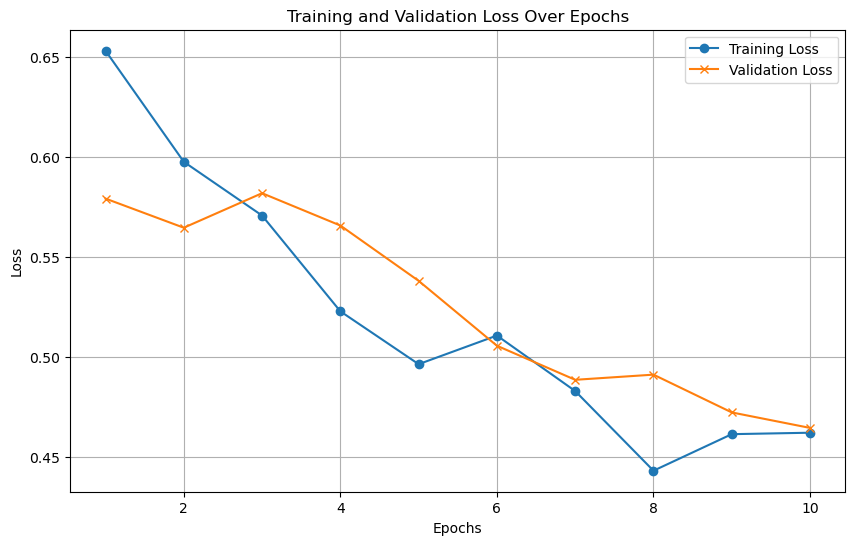

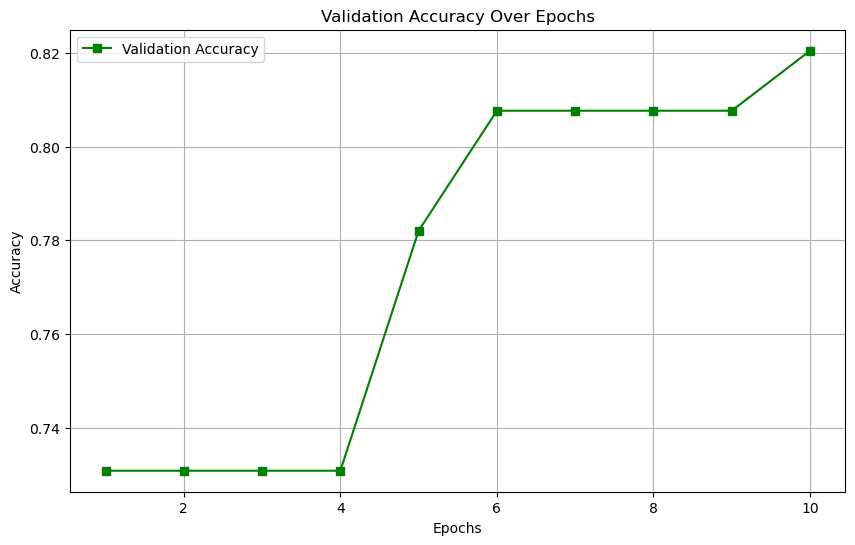

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", marker='s', color='g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

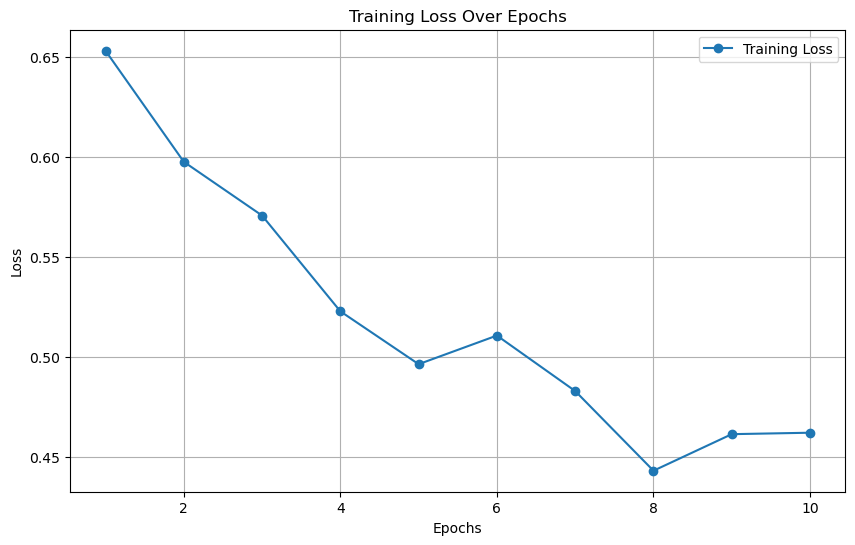

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# model_path = "/home/eflammere/QuantumIC/Quantum/notebooks/model_checkpoint_epoch_6.pth"
# model.load_state_dict(torch.load(model_path, weights_only=True))

test_loss = 0.0
test_labels, test_predictions = [], []

model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()
        test_labels.append(labels)
        test_predictions.append(output)

test_labels = torch.cat(test_labels)
test_predictions = torch.cat(test_predictions)

test_accuracy = accuracy_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy()
)
test_precision = precision_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_recall = recall_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_f1 = f1_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_auc = roc_auc_score(
    test_labels.cpu().numpy(), test_predictions[:, 1].cpu().numpy()
)

print("\nFinal Test Evaluation:")
print(f"Test Loss: {test_loss / len(dataloader_test):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")



Final Test Evaluation:
Test Loss: 0.4965
Test Accuracy: 0.7885
Test Precision: 0.7744
Test Recall: 0.7885
Test F1 Score: 0.7690
Test AUC: 0.8035


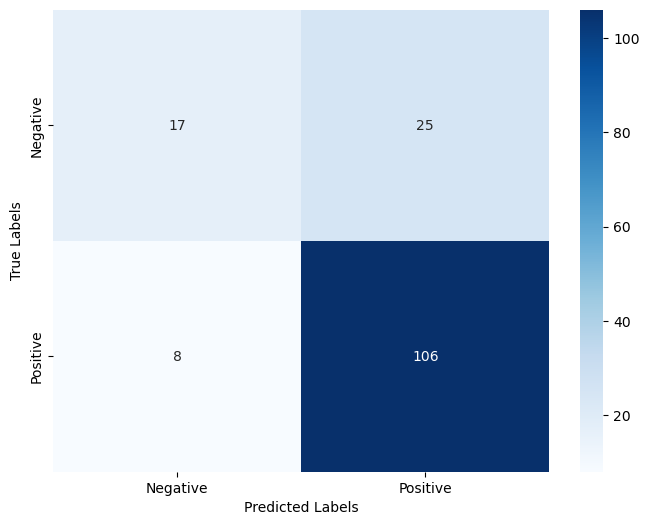

In [35]:
cm = confusion_matrix(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()